In [ ]:
# !pip install pandas matplotlib

In [22]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Vectorpreallocated': '||||',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----',
    'Mean': '',
    'Median': '||||||',
    'Max': '\\\\\\\\\\\\',
    '95th': '//',
    '98th': '----',
    '99th': '\\\\'
}

linestyle = {
    'vector': '-',
    'vectorpreallocated': '--',
    'skiplist': '--',
    'hashskiplist': '-.',
    'hashlinklist': ':'
}

alpha = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    # 'Vector': 'darkslateblue',
    # 'Skiplist': 'slategray',
    # 'Hashskiplist': 'darkkhaki',
    # 'Hashlinklist': 'chocolate'
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Vectorpreallocated': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Vectorpreallocated': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black',
    'Mean': 'black',
    'Median': 'black',
    'Max': 'black',
    '95th': 'black',
    '98th': 'black',
    '99th': 'black'
}

label = {
    'vector': 'vector',
    'vectorpreallocated': 'vector preallocated',
    'skiplist': 'skiplist',
    'hashskiplist': 'hash skiplist',
    'hashlinklist': 'hash linklist',
    'Mean': 'mean',
    'Median': 'median',
    'Max': 'max',
    '95th': '95th',
    '98th': '98th',
    '99th': '99th'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [23]:
def get_properties(key: str) -> Dict[str, str]:
    if key.lower() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": "black",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            "linestyle": linestyle.get(key.lower()),
            # "hatch": hatch.get(key.capitalize()),
            # "linewidth": linewidth.get(key.capitalize()),
            # "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [24]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int, pqs: int, epp: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}-{epp}-PQS-{pqs}"
    )


def get_log_file_path(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size, point_queries, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}/workload.log"
    return f"{get_exp_dirname(query_type, selectivity, entry_size, point_queries, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}/workload.log"

In [144]:
def prepare_dataframe(log_file_path: str, key: str="RangeQueryTime: ") -> pd.DataFrame:
    ff = open(log_file_path, "r")
    range_quereis = []

    for line in ff.readlines():
        if key in line:
            range_quereis.append(float(line.split(" ")[1]))
    
    return pd.DataFrame(range_quereis, columns=["TimeTaken"])


def process_file(path):
    ff = open(path, "r")

    for line in ff.readlines():
        if "Total time taken by workload =" in line:
            return float(line.split("Total time taken by workload = ")[1].split(" ")[0]) / 1000

In [174]:
point_queries = [120, 1200, 12000, 120000] #, 120, 2400, 7200, 12000]
memtables = ["Vector", "SkipList", "Hashskiplist", "Hashlinklist"]
prefixlen = 4
bucket_count = 100000
entry_size = 64
inserts = 120000
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
selectivity = 0


data = {
    "vector": [],
    "skiplist": [], 
    "hashskiplist": [], 
    "hashlinklist": [],
}

for pqs in point_queries:

    for memtable in memtables:
        query_type = "Interleaved-PQ-"
        query_type += memtable.lower()

        path = get_log_file_path(
            query_type,
            inserts,
            pqs,
            range_queries,
            selectivity,
            memtable,
            entry_size,
            number_of_entries_per_page,
            number_of_pages,
            prefixlen,
            bucket_count,
        )

        # df = prepare_dataframe(path, "PointQueryTime:")
        total_operations = inserts + pqs + range_queries
        avg_operational_latency = process_file(path) / total_operations

        data[memtable.lower()].append({
            "pointQueries": pqs,
            "AvgPointQueryLatency": avg_operational_latency
        })

for memtable in memtables:
    query_type = "Only-Inserts-"
    query_type += memtable.lower()

    path = get_log_file_path(
        query_type,
        inserts,
        0,
        0,
        selectivity,
        memtable,
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    total_operations = inserts
    avg_operational_latency = process_file(path) / total_operations

    data[memtable.lower()].append({
        "pointQueries": 0,
        "AvgPointQueryLatency": avg_operational_latency
    })


In [175]:
data

{'vector': [{'pointQueries': 120, 'AvgPointQueryLatency': 94.64104929237429},
  {'pointQueries': 1200, 'AvgPointQueryLatency': 375.6129054620462},
  {'pointQueries': 12000, 'AvgPointQueryLatency': 2948.1561419242425},
  {'pointQueries': 120000, 'AvgPointQueryLatency': 15941.9733203875},
  {'pointQueries': 0, 'AvgPointQueryLatency': 80.18565357499999}],
 'skiplist': [{'pointQueries': 120, 'AvgPointQueryLatency': 80.12414558774559},
  {'pointQueries': 1200, 'AvgPointQueryLatency': 79.4089925990099},
  {'pointQueries': 12000, 'AvgPointQueryLatency': 72.94981242424242},
  {'pointQueries': 120000, 'AvgPointQueryLatency': 40.20522999583333},
  {'pointQueries': 0, 'AvgPointQueryLatency': 80.20725317499999}],
 'hashskiplist': [{'pointQueries': 120,
   'AvgPointQueryLatency': 80.11402536630037},
  {'pointQueries': 1200, 'AvgPointQueryLatency': 79.40297345709571},
  {'pointQueries': 12000, 'AvgPointQueryLatency': 72.94364243181819},
  {'pointQueries': 120000, 'AvgPointQueryLatency': 40.189359145

In [176]:
data['hashskiplist']

[{'pointQueries': 120, 'AvgPointQueryLatency': 80.11402536630037},
 {'pointQueries': 1200, 'AvgPointQueryLatency': 79.40297345709571},
 {'pointQueries': 12000, 'AvgPointQueryLatency': 72.94364243181819},
 {'pointQueries': 120000, 'AvgPointQueryLatency': 40.189359145833336},
 {'pointQueries': 0, 'AvgPointQueryLatency': 80.19106030833333}]

In [177]:
point_queries
[d['AvgPointQueryLatency'] for d in sorted(data['vector'], key=lambda x: x['pointQueries'])]

[80.18565357499999,
 94.64104929237429,
 375.6129054620462,
 2948.1561419242425,
 15941.9733203875]

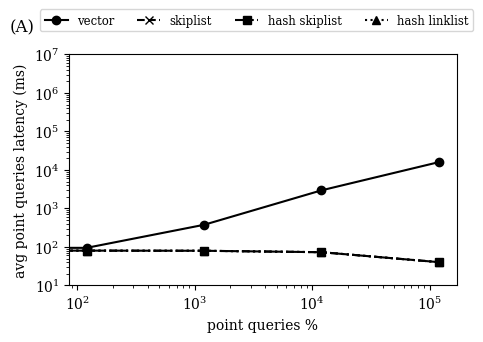

In [179]:
def get_properties(key: str) -> Dict[str, str]:
    if key.lower() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": "black",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            "linestyle": linestyle.get(key.lower()),
            # "hatch": hatch.get(key.capitalize()),
            # "linewidth": linewidth.get(key.capitalize()),
            # "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

point_queries = [0, 120, 1200, 12000, 120000]

fig, ax = plt.subplots(figsize=(5,3))

xpoints = [p for p in point_queries]

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['vector'], key=lambda x: x['pointQueries'])],
    label='vector',
    **get_properties('vector'),
    marker='o'
)

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['skiplist'], key=lambda x: x['pointQueries'])],
    label='skiplist',
    **get_properties('skiplist'),
    marker='x'
)

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['hashskiplist'], key=lambda x: x['pointQueries'])],
    label='hash skiplist',
    **get_properties('hashskiplist'),
    marker='s'
)

ax.plot(
    xpoints,
    [d['AvgPointQueryLatency'] for d in sorted(data['hashlinklist'], key=lambda x: x['pointQueries'])],
    label='hash linklist',
    **get_properties('hashlinklist'),
    marker='^'
)

# ax.set_xticks(xpoints)
# ax.set_xticklabels([f"{p/inserts}" for p in point_queries])

ax.set_ylabel('avg point queries latency (ms)')
ax.set_xlabel('point queries %')
ax.set_ylim(bottom=10**1, top=10**7)

# ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

ax.text(-0.12, 1.12, '(A)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

fig.legend(loc='upper center', ncol=4, fontsize='small', bbox_to_anchor=(0.5, 1.05))
plt.show()

In [153]:
point_queries[0]/inserts

0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


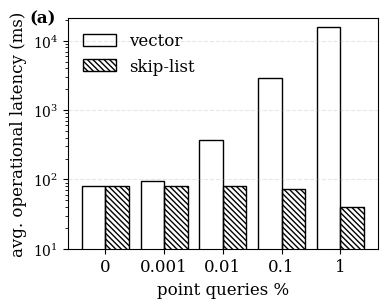

In [211]:
def get_properties(key: str) -> Dict[str, str]:
    if key.lower() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": "None",
            "edgecolor": "black",
            # "linestyle": linestyle.get(key.lower()),
            "hatch": hatch.get(key.capitalize()),
            # "linewidth": linewidth.get(key.capitalize()),
            # "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

labels = [f"{entry['pointQueries']}" for entry in sorted(data['vector'], key=lambda x: x['pointQueries'])]
vector_latencies = [entry['AvgPointQueryLatency'] for entry in sorted(data['vector'], key=lambda x: x['pointQueries'])]
skiplist_latencies = [entry['AvgPointQueryLatency'] for entry in sorted(data['skiplist'], key=lambda x: x['pointQueries'])]
# hashskiplist_latencies = [entry['AvgPointQueryLatency'] for entry in sorted(data['hashskiplist'], key=lambda x: x['pointQueries'])]
# hashlinklist_latencies = [entry['AvgPointQueryLatency'] for entry in sorted(data['hashlinklist'], key=lambda x: x['pointQueries'])]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(4,3))
rects1 = ax.bar(x - width*0.5, vector_latencies, width, label='vector', **get_properties('vector'))
rects2 = ax.bar(x + width*0.5, skiplist_latencies, width, label='skip-list', **get_properties('skiplist')) 
# rects3 = ax.bar(x + width/2, hashskiplist_latencies, width, label='hash skip-list', **get_properties('hashskiplist'))
# rects4 = ax.bar(x + width*1.5, hashlinklist_latencies, width, label='hash linked-list', **get_properties('hashlinklist'))

ax.set_yscale('log')
ax.set_ylim(bottom=10**1)

ax.set_ylabel('avg. operational latency (ms)', fontsize=12)

ax.set_xlabel('point queries %', fontsize=12)

ax.set_xticks(x)

xlabel = ['0', '0.001', '0.01', '0.1', '1']

ax.set_xticklabels(xlabel, fontsize=12)

ax.text(-0.08, 1.0, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, fontweight='bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)

ax.legend(frameon=False, fontsize=12)

fig.savefig('motivation-a.eps', format='eps', bbox_inches='tight')

In [207]:
vector_latencies

[80.18565357499999,
 94.64104929237429,
 375.6129054620462,
 2948.1561419242425,
 15941.9733203875]